# Laboratorio 1 (AlpesHearth): Exploración, preparación y regresión lineal

En este notebook se encuentra:

1. Exploración y perfilamiento (calidad: completitud, unicidad, consistencia, validez).
2. Limpieza y preparación con justificación.
3. Dos modelos de regresión lineal con **pipelines** y preparación distinta.
4. Tabla comparativa en test con **RMSE, MAE y R2**.
5. Importancia de variables con base en el mejor modelo (coeficientes).
6. Validación de supuestos (gráficos de residuos) para apoyar interpretación.
7. Predicción sobre el archivo de test no etiquetado y exportación en CSV.

Nota importante (causa típica de R2 negativo):
- La columna **`Blood Pressure (mmHg)`** viene como texto tipo `"120/80"`. Si se deja como categórica, crea miles de dummies y generaliza muy mal.
- Aquí la usamos solo para **completar** `Systolic BP` y `Diastolic BP`, y luego la excluimos del modelado.


## 0. Imports y constantes

In [84]:

import pandas as pd
import numpy as np
import re

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression, RidgeCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

from sklearn.base import BaseEstimator, TransformerMixin

pd.set_option("display.max_columns", 200)
pd.set_option("display.width", 140)

RANDOM_STATE = 42
TEST_SIZE = 0.25

TARGET = "CVD Risk Score"
AUX_LABEL = "CVD Risk Level"


## 1. Cargar datos y diccionario

Punto clave: `Datos Test Lab 1.csv` usa `;` y el train usa `,`. Esta celda detecta el separador automáticamente.


In [85]:

def read_csv_auto_sep(path: str) -> pd.DataFrame:
    with open(path, "r", encoding="utf-8", errors="ignore") as f:
        first_line = f.readline()
    sep = ";" if first_line.count(";") > first_line.count(",") else ","
    return pd.read_csv(path, sep=sep)

train_path = "Datos Lab 1.csv"
test_path  = "Datos Test Lab 1.csv"
dicc_path  = "DiccPacientes.xlsx"

train_raw = read_csv_auto_sep(train_path)
test_raw  = read_csv_auto_sep(test_path)
dicc_raw  = pd.read_excel(dicc_path)
dicc_raw.columns = [c.strip() for c in dicc_raw.columns]

print("Train shape:", train_raw.shape)
print("Test  shape:", test_raw.shape)
display(dicc_raw.head(10))

print("Columnas extra en train (vs test):", sorted(list(set(train_raw.columns) - set(test_raw.columns))))


Train shape: (1639, 24)
Test  shape: (194, 23)


,Nombre Columna,Tipo de dato,Comentarios
0,Patient ID,String,Identificador del paciente
1,Date of Service,Date,Fecha de la atención
2,Sex,String,"Sexo (Femenino, Masculino)"
3,Age,Integer,Edad
4,Weight (kg),Float,Peso
5,Height (m),Float,Altura
6,BMI,Float,Índice de masa corporal
7,Abdominal Circumference (cm),Float,Circunferencia abdominal
8,Blood Pressure (mmHg),String,"Presión sanguínea, de la forma ""<Presión arter..."
9,Total Cholesterol (mg/dL),Float,Colesterol total


Columnas extra en train (vs test): ['CVD Risk Level']


## 2. Exploración inicial

In [86]:

display(train_raw.head())
display(test_raw.head())

print("Tipos de datos (train):")
display(train_raw.dtypes)

print("Describe numérico (train):")
display(train_raw.select_dtypes(include=[np.number]).describe())

print("Describe del target (train):")
display(train_raw[TARGET].describe())


,Patient ID,Date of Service,Sex,Age,Weight (kg),Height (m),BMI,Abdominal Circumference (cm),Blood Pressure (mmHg),Total Cholesterol (mg/dL),HDL (mg/dL),Fasting Blood Sugar (mg/dL),Smoking Status,Diabetes Status,Physical Activity Level,Family History of CVD,Height (cm),Waist-to-Height Ratio,Systolic BP,Diastolic BP,Blood Pressure Category,Estimated LDL (mg/dL),CVD Risk Score,CVD Risk Level
0,isDx5313,"November 08, 2023",M,44.0,114.300,1.720,38.600,100.000,112/83,228.0,77.0,91.0,Y,Y,High,N,172.000,0.581,112.0,83.0,Hypertension Stage 1,121.0,19.880,HIGH
1,LHCK2961,20/03/2024,F,57.0,92.923,1.842,33.116,106.315,101/91,158.0,71.0,76.0,N,Y,High,Y,184.172,0.577,101.0,91.0,Hypertension Stage 2,57.0,16.833,INTERMEDIARY
2,WjVn1699,2021-05-27,F,NaN,73.400,1.650,27.000,78.100,90/74,135.0,60.0,150.0,N,N,High,N,165.000,0.473,90.0,74.0,Normal,45.0,12.600,LOW
3,dCDO1109,"April 18, 2022",F,35.0,113.300,1.780,35.800,79.600,92/89,158.0,34.0,111.0,Y,N,Moderate,Y,178.000,0.447,92.0,89.0,Hypertension Stage 1,94.0,14.920,HIGH
4,pnpE1080,01/11/2024,F,48.0,102.200,1.750,33.400,106.700,121/68,207.0,49.0,147.0,Y,Y,Low,Y,175.000,0.610,121.0,68.0,Elevated,128.0,18.870,HIGH


,Patient ID,Date of Service,Sex,Age,Weight (kg),Height (m),BMI,Abdominal Circumference (cm),Blood Pressure (mmHg),Total Cholesterol (mg/dL),HDL (mg/dL),Fasting Blood Sugar (mg/dL),Smoking Status,Diabetes Status,Physical Activity Level,Family History of CVD,Height (cm),Waist-to-Height Ratio,Systolic BP,Diastolic BP,Blood Pressure Category,Estimated LDL (mg/dL),CVD Risk Score
0,WYTG8678,1/12/2021,M,44.0,51.936,1.936,36.442,115.755,105/108,107.0,52.0,125.0,Y,Y,Low,N,193.61,0.598,105.0,108.0,Hypertension Stage 2,25.0,19.793418
1,yloc1993,12-25-2020,F,30.0,115.000,1.830,34.300,93.600,139/79,100.0,31.0,125.0,Y,N,Moderate,N,183.00,0.511,139.0,79.0,Hypertension Stage 1,39.0,19.274552
2,DDwq7653,23-sep-21,M,38.0,63.300,1.700,21.900,93.800,93/67,NaN,76.0,73.0,N,Y,High,N,170.00,0.552,93.0,67.0,Normal,182.0,16.532321
3,YTcX6704,3/03/2021,F,58.0,72.300,1.740,23.900,91.600,99/90,208.0,63.0,114.0,N,N,High,N,174.00,0.526,99.0,90.0,Hypertension Stage 2,115.0,15.763443
4,lZLi8935,06-14-2022,M,51.0,57.600,1.810,17.600,100.000,97/84,137.0,48.0,113.0,Y,N,High,N,181.00,0.552,97.0,84.0,Hypertension Stage 1,59.0,15.213202


Tipos de datos (train):


Patient ID                          str
Date of Service                     str
Sex                                 str
Age                             float64
Weight (kg)                     float64
Height (m)                      float64
BMI                             float64
Abdominal Circumference (cm)    float64
Blood Pressure (mmHg)               str
Total Cholesterol (mg/dL)       float64
HDL (mg/dL)                     float64
Fasting Blood Sugar (mg/dL)     float64
Smoking Status                      str
Diabetes Status                     str
Physical Activity Level             str
Family History of CVD               str
Height (cm)                     float64
Waist-to-Height Ratio           float64
Systolic BP                     float64
Diastolic BP                    float64
Blood Pressure Category             str
Estimated LDL (mg/dL)           float64
CVD Risk Score                  float64
CVD Risk Level                      str
dtype: object

Describe numérico (train):


,Age,Weight (kg),Height (m),BMI,Abdominal Circumference (cm),Total Cholesterol (mg/dL),HDL (mg/dL),Fasting Blood Sugar (mg/dL),Height (cm),Waist-to-Height Ratio,Systolic BP,Diastolic BP,Estimated LDL (mg/dL),CVD Risk Score
count,1571.000000,1566.000000,1578.000000,1586.000000,1578.000000,1571.000000,1557.000000,1585.000000,1571.000000,1563.000000,1578.000000,1554.000000,1582.000000,1610.000000
mean,46.803186,85.666006,1.757439,28.424744,91.538861,199.043673,56.183558,117.836860,175.770082,0.522440,125.632637,82.887536,113.235896,18.227281
std,13.039479,21.712504,0.118012,7.309275,13.427985,59.388670,16.721702,32.379634,11.695880,0.085692,22.577463,15.503625,61.435291,10.767666
min,6.134000,13.261000,1.371000,4.317000,49.542000,-1.256000,0.008000,15.306000,136.498000,0.250000,49.914000,31.720000,-92.055000,-20.057000
25%,37.000000,67.100000,1.666500,22.600000,79.700000,150.000000,42.000000,92.000000,167.000000,0.453000,108.000000,71.000000,62.000000,15.150000
50%,46.000000,86.314000,1.760000,28.000000,91.200000,199.000000,56.000000,115.000000,176.000000,0.519000,125.000000,82.000000,112.000000,16.967000
75%,55.000000,104.801500,1.850000,33.963000,102.267250,250.000000,70.000000,139.000000,185.000000,0.582000,141.000000,93.000000,159.000000,18.900000
max,89.420000,158.523000,2.146000,53.028000,136.336000,385.679000,110.315000,219.667000,214.394000,0.804000,202.711000,134.066000,317.314000,114.980000


Describe del target (train):


count    1610.000000
mean       18.227281
std        10.767666
min       -20.057000
25%        15.150000
50%        16.967000
75%        18.900000
max       114.980000
Name: CVD Risk Score, dtype: float64

## 3. Perfilamiento de calidad (completitud, unicidad, consistencia, validez)

In [87]:

# Completitud
missing_train = (train_raw.isna().mean() * 100).sort_values(ascending=False)
missing_test  = (test_raw.isna().mean() * 100).sort_values(ascending=False)

print("Missing % (train) - top 15")
display(missing_train.head(15))

print("Missing % (test) - top 15")
display(missing_test.head(15))

print("Filas en train con target missing:", train_raw[TARGET].isna().sum())

# Unicidad
print("Duplicados exactos train:", train_raw.duplicated().sum())
print("Duplicados exactos test :", test_raw.duplicated().sum())


Missing % (train) - top 15


Diastolic BP                    5.186089
HDL (mg/dL)                     5.003051
Waist-to-Height Ratio           4.636974
Weight (kg)                     4.453935
Height (cm)                     4.148871
Age                             4.148871
Total Cholesterol (mg/dL)       4.148871
Height (m)                      3.721782
Abdominal Circumference (cm)    3.721782
Systolic BP                     3.721782
Estimated LDL (mg/dL)           3.477730
Fasting Blood Sugar (mg/dL)     3.294692
BMI                             3.233679
CVD Risk Score                  1.769372
Patient ID                      0.000000
dtype: float64

Missing % (test) - top 15


Age                             5.670103
Weight (kg)                     5.154639
BMI                             4.123711
HDL (mg/dL)                     4.123711
Height (m)                      3.608247
Abdominal Circumference (cm)    3.608247
Height (cm)                     3.608247
Total Cholesterol (mg/dL)       3.092784
Systolic BP                     3.092784
Waist-to-Height Ratio           3.092784
Fasting Blood Sugar (mg/dL)     2.577320
Estimated LDL (mg/dL)           2.577320
Diastolic BP                    2.577320
Family History of CVD           0.000000
Blood Pressure Category         0.000000
dtype: float64

Filas en train con target missing: 29
Duplicados exactos train: 151
Duplicados exactos test : 5


### 3.1 Consistencia (categóricas)

In [88]:

CAT_COLS = [
    "Sex",
    "Smoking Status",
    "Diabetes Status",
    "Physical Activity Level",
    "Family History of CVD",
    "Blood Pressure Category",
]

for c in CAT_COLS:
    print("\n---", c, "---")
    display(train_raw[c].astype(str).value_counts().head(20))



--- Sex ---


Sex
M    821
F    818
Name: count, dtype: int64


--- Smoking Status ---


Smoking Status
Y    850
N    789
Name: count, dtype: int64


--- Diabetes Status ---


Diabetes Status
N    821
Y    818
Name: count, dtype: int64


--- Physical Activity Level ---


Physical Activity Level
High        582
Moderate    537
Low         520
Name: count, dtype: int64


--- Family History of CVD ---


Family History of CVD
N    820
Y    819
Name: count, dtype: int64


--- Blood Pressure Category ---


Blood Pressure Category
Hypertension Stage 2    680
Hypertension Stage 1    527
Normal                  321
Elevated                111
Name: count, dtype: int64

### 3.2 Validez (valores imposibles)

In [89]:

print("LDL negativo (train):", (train_raw["Estimated LDL (mg/dL)"] < 0).sum())
print("Colesterol total negativo (train):", (train_raw["Total Cholesterol (mg/dL)"] < 0).sum())

print("Peso <= 0 (train):", (train_raw["Weight (kg)"] <= 0).sum(skipna=True))
print("Altura (m) <= 0 (train):", (train_raw["Height (m)"] <= 0).sum(skipna=True))
print("Edad <= 0 (train):", (train_raw["Age"] <= 0).sum(skipna=True))


LDL negativo (train): 16
Colesterol total negativo (train): 1
Peso <= 0 (train): 0
Altura (m) <= 0 (train): 0
Edad <= 0 (train): 0


## 4. Limpieza y preparación (justificada)

Reglas:
- Quitar duplicados exactos.
- Quitar filas sin `CVD Risk Score` en train.
- LDL negativo y colesterol total negativo se vuelven NaN.
- Completar `Systolic BP` y `Diastolic BP` desde `Blood Pressure (mmHg)` si es posible.
- Normalizar categóricas con `strip()`.

Importante:
- `Blood Pressure (mmHg)` se usa para completar BP numérica, pero **NO** se usa como predictor.


In [90]:

def parse_bp_series(series: pd.Series):
    sys_vals, dia_vals = [], []
    for v in series.astype(str):
        m = re.match(r"^\s*(\d+)\s*/\s*(\d+)\s*$", v)
        if m:
            sys_vals.append(float(m.group(1)))
            dia_vals.append(float(m.group(2)))
        else:
            sys_vals.append(np.nan)
            dia_vals.append(np.nan)
    return pd.Series(sys_vals, index=series.index), pd.Series(dia_vals, index=series.index)

def normalize_categories(df: pd.DataFrame, cat_cols: list[str]) -> pd.DataFrame:
    df = df.copy()
    for c in cat_cols:
        df[c] = df[c].astype("string").str.strip()
    return df

def clean_common(df: pd.DataFrame, cat_cols: list[str] = None) -> pd.DataFrame:
    if cat_cols is None:
        cat_cols = CAT_COLS

    df = df.copy()
    df = normalize_categories(df, cat_cols)

    # Validez
    df.loc[df["Estimated LDL (mg/dL)"] < 0, "Estimated LDL (mg/dL)"] = np.nan
    df.loc[df["Total Cholesterol (mg/dL)"] < 0, "Total Cholesterol (mg/dL)"] = np.nan

    # Completar BP numérica desde el string
    if "Blood Pressure (mmHg)" in df.columns:
        sys_bp, dia_bp = parse_bp_series(df["Blood Pressure (mmHg)"])
        df["Systolic BP"] = df["Systolic BP"].fillna(sys_bp)
        df["Diastolic BP"] = df["Diastolic BP"].fillna(dia_bp)

    return df

train = train_raw.drop_duplicates().dropna(subset=[TARGET]).copy()
train = clean_common(train)

test = test_raw.drop_duplicates().copy()
test = clean_common(test)

print("Train limpio shape:", train.shape)
print("Test  limpio shape:", test.shape)

print("LDL negativo (train limpio):", (train["Estimated LDL (mg/dL)"] < 0).sum(skipna=True))
print("Colesterol total negativo (train limpio):", (train["Total Cholesterol (mg/dL)"] < 0).sum(skipna=True))


Train limpio shape: (1460, 24)
Test  limpio shape: (189, 23)
LDL negativo (train limpio): 0
Colesterol total negativo (train limpio): 0


## 5. Visualizaciones útiles (target y correlaciones)

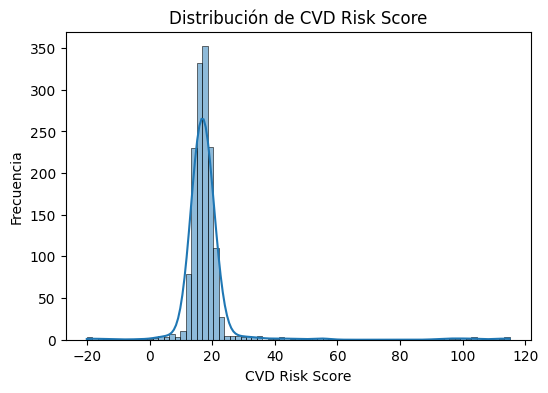

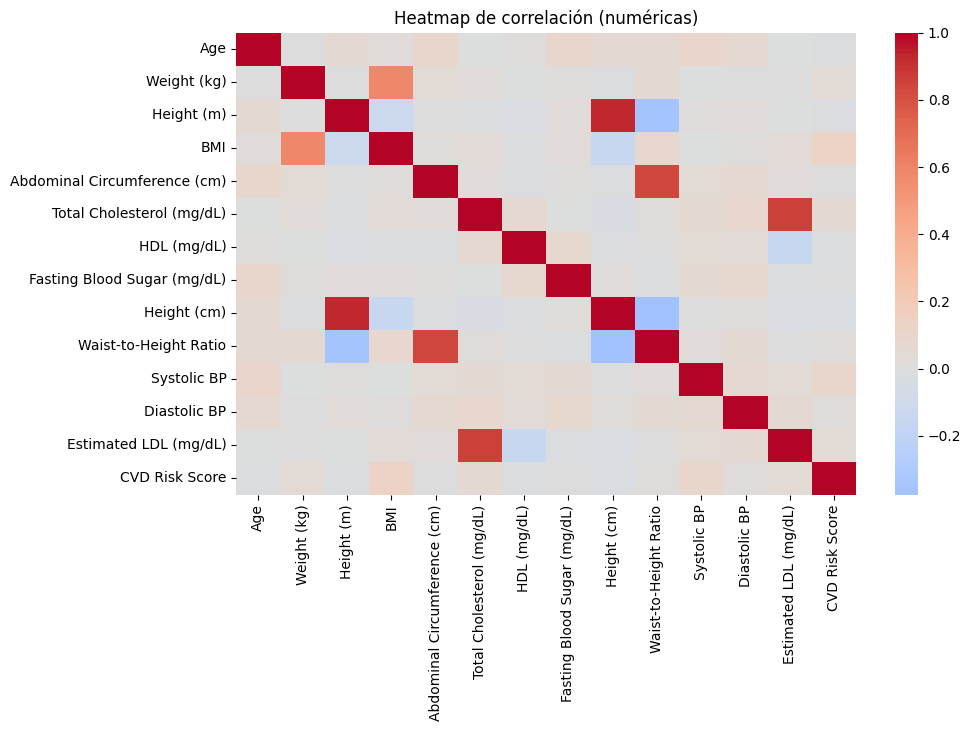

BMI                          0.124398
Systolic BP                  0.092954
Total Cholesterol (mg/dL)    0.055598
Weight (kg)                  0.043229
Estimated LDL (mg/dL)        0.041459
Height (cm)                  0.024762
Diastolic BP                 0.022924
Waist-to-Height Ratio        0.022510
Height (m)                   0.019555
Age                          0.013410
Name: CVD Risk Score, dtype: float64

In [91]:

plt.figure(figsize=(6,4))
sns.histplot(train[TARGET], kde=True)
plt.title("Distribución de CVD Risk Score")
plt.xlabel(TARGET)
plt.ylabel("Frecuencia")
plt.show()

corr = train.select_dtypes(include=[np.number]).corr()
plt.figure(figsize=(10,6))
sns.heatmap(corr, cmap="coolwarm", center=0)
plt.title("Heatmap de correlación (numéricas)")
plt.show()

target_corr = corr[TARGET].drop(TARGET).abs().sort_values(ascending=False)
display(target_corr.head(10))


## 6. Definir X, y y partición train-test (enunciado: semilla 42 y 25%)

Decisión crítica (para evitar R2 negativo):
- Excluimos `Blood Pressure (mmHg)` del modelado porque es texto con alta cardinalidad.


In [92]:

DROP_ALWAYS = ["Patient ID", "Date of Service", AUX_LABEL, "Blood Pressure (mmHg)"]

X = train.drop(columns=[TARGET] + DROP_ALWAYS).copy()
y = train[TARGET].copy()

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=TEST_SIZE, random_state=RANDOM_STATE
)

print("X_train:", X_train.shape, "X_test:", X_test.shape)


X_train: (1095, 19) X_test: (365, 19)


## 7. Dos modelos (pipelines) con preparación distinta

Modelo 1 (baseline OLS):
- Imputación + OneHot + LinearRegression

Modelo 2 (RidgeCV):
- Imputación + escalado numérico + OneHot + RidgeCV (regresión lineal regularizada)

Por qué Ridge aquí:
- Sigue siendo regresión lineal.
- Ayuda con multicolinealidad y alta dimensionalidad por dummies, mejora generalización.


In [93]:

def build_preprocess(X_sample: pd.DataFrame, scale_numeric: bool) -> ColumnTransformer:
    num_cols = X_sample.select_dtypes(include=[np.number]).columns.tolist()
    cat_cols = [c for c in X_sample.columns if c not in num_cols]

    num_steps = [("imputer", SimpleImputer(strategy="median"))]
    if scale_numeric:
        num_steps.append(("scaler", StandardScaler()))

    preprocess = ColumnTransformer(
        transformers=[
            ("num", Pipeline(num_steps), num_cols),
            ("cat", Pipeline([
                ("imputer", SimpleImputer(strategy="most_frequent")),
                ("onehot", OneHotEncoder(handle_unknown="ignore", drop="first")),
            ]), cat_cols),
        ],
        remainder="drop"
    )
    return preprocess

# Modelo 1: OLS
model_1 = Pipeline([
    ("preprocess", build_preprocess(X_train, scale_numeric=False)),
    ("reg", LinearRegression()),
])

# Modelo 2: RidgeCV (elige alpha automáticamente)
alphas = np.logspace(-3, 3, 25)
model_2 = Pipeline([
    ("preprocess", build_preprocess(X_train, scale_numeric=True)),
    ("reg", RidgeCV(alphas=alphas)),
])


## 8. Evaluación cuantitativa (RMSE, MAE, R2) y baseline del promedio

In [94]:

def eval_model(model, X_tr, y_tr, X_te, y_te):
    model.fit(X_tr, y_tr)
    pred = model.predict(X_te)
    rmse = np.sqrt(mean_squared_error(y_te, pred))
    mae  = mean_absolute_error(y_te, pred)
    r2   = r2_score(y_te, pred)
    return rmse, mae, r2

# Baseline: predecir el promedio del target
baseline_pred = np.repeat(y_train.mean(), len(y_test))
baseline_rmse = np.sqrt(mean_squared_error(y_test, baseline_pred))
baseline_mae  = mean_absolute_error(y_test, baseline_pred)
baseline_r2   = r2_score(y_test, baseline_pred)

rmse1, mae1, r21 = eval_model(model_1, X_train, y_train, X_test, y_test)
rmse2, mae2, r22 = eval_model(model_2, X_train, y_train, X_test, y_test)

results = pd.DataFrame([
    {"Modelo": "Baseline (promedio)", "RMSE": baseline_rmse, "MAE": baseline_mae, "R2": baseline_r2},
    {"Modelo": "Modelo 1 (OLS)", "RMSE": rmse1, "MAE": mae1, "R2": r21},
    {"Modelo": "Modelo 2 (RidgeCV)", "RMSE": rmse2, "MAE": mae2, "R2": r22},
]).sort_values("RMSE", ascending=True)

display(results)

best_row = results[results["Modelo"].str.contains("Modelo")].sort_values("RMSE").iloc[0]
best_name = best_row["Modelo"]
best_model = model_1 if best_name == "Modelo 1 (OLS)" else model_2

print("Mejor modelo (por RMSE):", best_name)

if best_name == "Modelo 2 (RidgeCV)":
    print("Alpha seleccionado (RidgeCV):", best_model.named_steps["reg"].alpha_)


,Modelo,RMSE,MAE,R2
2,Modelo 2 (RidgeCV),10.618083,3.541954,0.031460
1,Modelo 1 (OLS),10.641733,3.716611,0.027140
0,Baseline (promedio),10.789180,4.189534,-0.000005


Mejor modelo (por RMSE): Modelo 2 (RidgeCV)
Alpha seleccionado (RidgeCV): 100.0


## 9. Importancia de variables: coeficientes del mejor modelo

Extraemos:
- nombres de features (después del preprocesamiento)
- coeficientes del regresor (OLS o Ridge)

Se ordena por valor absoluto para reportar variables más influyentes.


In [95]:

best_model.fit(X_train, y_train)

preprocess_step = best_model.named_steps["preprocess"]
feature_names = preprocess_step.get_feature_names_out()

coefs = best_model.named_steps["reg"].coef_

coef_df = (
    pd.DataFrame({"Feature": feature_names, "Coef": coefs})
      .assign(AbsCoef=lambda d: d["Coef"].abs())
      .sort_values("AbsCoef", ascending=False)
)

display(coef_df.head(25))


,Feature,Coef,AbsCoef
15,cat__Diabetes Status_Y,1.880506,1.880506
3,num__BMI,1.459104,1.459104
21,cat__Blood Pressure Category_Normal,-1.416710,1.416710
18,cat__Family History of CVD_Y,-0.975310,0.975310
10,num__Systolic BP,0.768703,0.768703
16,cat__Physical Activity Level_Low,-0.670177,0.670177
0,num__Age,-0.543642,0.543642
5,num__Total Cholesterol (mg/dL),0.509310,0.509310
17,cat__Physical Activity Level_Moderate,0.463704,0.463704
1,num__Weight (kg),-0.429603,0.429603


## 10. Validación visual de supuestos (residuos)

Para apoyar interpretación:
- residuos vs predicción
- histograma de residuos
- QQ plot

Esto no prueba formalmente, pero es suficiente para la etapa cualitativa del laboratorio.


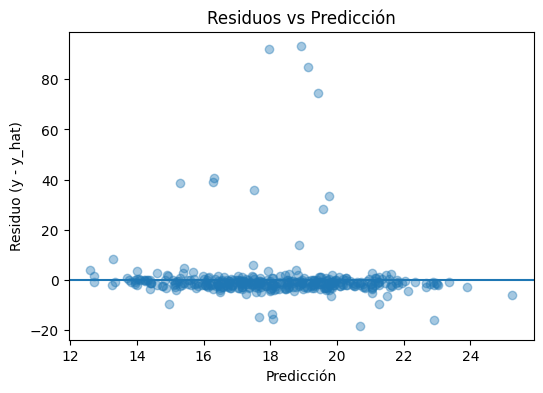

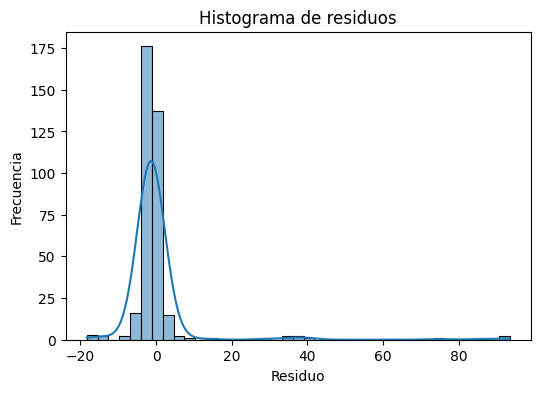

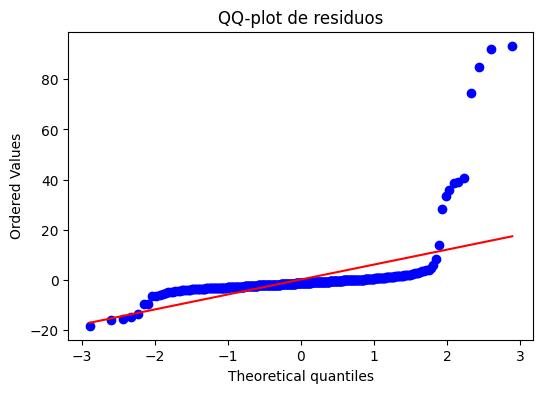

In [96]:

y_pred = best_model.predict(X_test)
residuals = y_test - y_pred

plt.figure(figsize=(6,4))
plt.scatter(y_pred, residuals, alpha=0.4)
plt.axhline(0)
plt.title("Residuos vs Predicción")
plt.xlabel("Predicción")
plt.ylabel("Residuo (y - y_hat)")
plt.show()

plt.figure(figsize=(6,4))
sns.histplot(residuals, kde=True)
plt.title("Histograma de residuos")
plt.xlabel("Residuo")
plt.ylabel("Frecuencia")
plt.show()

import scipy.stats as stats
plt.figure(figsize=(6,4))
stats.probplot(residuals, dist="norm", plot=plt)
plt.title("QQ-plot de residuos")
plt.show()


## 11. Entrenar el mejor modelo con TODO el train y predecir el test no etiquetado

Reglas importantes:
- Limpiar el test original (para construir X_submit).
- Exportar usando el **test_raw** (para conservar filas y orden exacto del archivo entregable).
- Alinear columnas con `reindex` para evitar errores por columnas faltantes.


In [97]:

# 1) Train completo 
X_full = train.drop(columns=[TARGET] + DROP_ALWAYS).copy()
y_full = train[TARGET].copy()

# 2) Partimos del test ORIGINAL para conservar filas y orden del archivo 
test_submit = clean_common(test_raw.copy(), CAT_COLS)

# 3) Armamos X_submit y lo alineamos con X_full
X_submit = test_submit.drop(columns=DROP_ALWAYS, errors="ignore").copy()
X_submit = X_submit.reindex(columns=X_full.columns)

# 4) Entrenar y predecir
best_model.fit(X_full, y_full)
test_pred = best_model.predict(X_submit)

# 5) Exportar el archivo final con el mismo formato del test (separador ;)
out = test_raw.copy()
out[TARGET] = test_pred

output_path = "Datos Test Lab 1.csv"
out.to_csv(output_path, index=False, sep=";")

print("Archivo generado para entrega:", output_path)
display(out.head())


Archivo generado para entrega: Datos Test Lab 1.csv


,Patient ID,Date of Service,Sex,Age,Weight (kg),Height (m),BMI,Abdominal Circumference (cm),Blood Pressure (mmHg),Total Cholesterol (mg/dL),HDL (mg/dL),Fasting Blood Sugar (mg/dL),Smoking Status,Diabetes Status,Physical Activity Level,Family History of CVD,Height (cm),Waist-to-Height Ratio,Systolic BP,Diastolic BP,Blood Pressure Category,Estimated LDL (mg/dL),CVD Risk Score
0,WYTG8678,1/12/2021,M,44.0,51.936,1.936,36.442,115.755,105/108,107.0,52.0,125.0,Y,Y,Low,N,193.61,0.598,105.0,108.0,Hypertension Stage 2,25.0,19.793418
1,yloc1993,12-25-2020,F,30.0,115.000,1.830,34.300,93.600,139/79,100.0,31.0,125.0,Y,N,Moderate,N,183.00,0.511,139.0,79.0,Hypertension Stage 1,39.0,19.274552
2,DDwq7653,23-sep-21,M,38.0,63.300,1.700,21.900,93.800,93/67,NaN,76.0,73.0,N,Y,High,N,170.00,0.552,93.0,67.0,Normal,182.0,16.532321
3,YTcX6704,3/03/2021,F,58.0,72.300,1.740,23.900,91.600,99/90,208.0,63.0,114.0,N,N,High,N,174.00,0.526,99.0,90.0,Hypertension Stage 2,115.0,15.763443
4,lZLi8935,06-14-2022,M,51.0,57.600,1.810,17.600,100.000,97/84,137.0,48.0,113.0,Y,N,High,N,181.00,0.552,97.0,84.0,Hypertension Stage 1,59.0,15.213202


## 12. Preguntas de análisis de resultados (responde aquí)

### ¿Cuál fue el valor de los diferentes coeficientes obtenidos en el mejor modelo?

El mejor modelo por RMSE fue **Modelo 2 (RidgeCV)** con **alpha = 100.0** e intercepto **17.7329**. Algunos de los coeficientes de mayor magnitud (según la tabla del notebook) fueron:

| Variable | Coeficiente |
|---|---:|
| Diabetes Status = Y | 1.8805 |
| BMI | 1.4591 |
| Blood Pressure Category = Normal | -1.4167 |
| Family History of CVD = Y | -0.9753 |
| Systolic BP | 0.7687 |
| Physical Activity Level = Low | -0.6702 |
| Age | -0.5436 |
| Total Cholesterol (mg/dL) | 0.5093 |
| Physical Activity Level = Moderate | 0.4637 |
| Weight (kg) | -0.4296 |

En variables numéricas el efecto se interpreta en escala estandarizada (cambio por 1 desviación estándar). En categóricas, el efecto es respecto a la categoría base (por `drop="first"` en el one-hot).

---

### A partir de la tabla comparativa, ¿cuál modelo ofrece el mejor rendimiento sobre el conjunto test? ¿Qué interpretación puedes darles a los valores obtenidos sobre las métricas de rendimiento?

Resultados en test:

| Modelo | RMSE | MAE | R2 |
|---|---:|---:|---:|
| Baseline (promedio) | 10.7892 | 4.1895 | -0.0000 |
| Modelo 1 (OLS) | 10.6417 | 3.7166 | 0.0271 |
| Modelo 2 (RidgeCV) | **10.6181** | **3.5420** | **0.0315** |

El mejor es **RidgeCV** porque logra el menor RMSE. RMSE penaliza más los errores grandes, MAE refleja el error típico y R2 indica cuánta variación del score explica el modelo. Aquí R2 es bajo, así que el modelo mejora frente al baseline pero la señal explicable con estas variables es limitada.

---

### ¿Cuáles variables fueron seleccionadas con el modelo seleccionado? A partir de estas, ¿qué interpretación de cara al problema puedes dar? Reflexiona sobre cómo este nuevo conocimiento podría ayudar a tomar decisiones en el contexto del problema.

Ridge no selecciona variables “eliminando” (como Lasso), pero se interpretan como más relevantes las de mayor magnitud. En este caso, las variables más influyentes se agrupan en: **composición corporal** (BMI/peso), **presión arterial** (Systolic BP y categoría), **perfil lipídico** (colesterol) y **condiciones/hábitos** (diabetes y nivel de actividad física). Para AlpesHearth, esto sugiere campañas enfocadas en hábitos modificables: aumentar actividad física, control de peso, educación sobre presión arterial y colesterol, y priorizar segmentos con diabetes o baja actividad física.

---

### A partir del contexto y los datos compartidos, ¿cómo representar la regresión lineal de forma matemática? Indique el método utilizado y el proceso para resolverlo.

La regresión lineal se expresa como:

\[
\hat{y} = \beta_0 + \sum_{j=1}^p \beta_j z_j
\]

donde \(z_j\) son variables tras el preprocesamiento (numéricas estandarizadas y dummies). El mejor modelo fue Ridge, que estima \(\beta\) minimizando:

\[
\|y - Z\beta\|^2 + \alpha \|\beta\|^2
\]

En el notebook, \(\alpha\) se selecciona con **RidgeCV** y el preprocesamiento se aplica dentro del pipeline para evitar leakage.

---

### En el ciclo de machine learning ¿Qué tipos de sesgo podría afectar los resultados y por qué? Describe dos tipos de sesgo.

**Sesgo de selección:** si el dataset no representa a la población objetivo, el modelo aprende patrones que no generalizan.  
**Sesgo de medición/calidad:** faltantes no aleatorios, valores inválidos o registros inconsistentes pueden sesgar entrenamiento e interpretación (por ejemplo, imputación sobre variables que faltan sistemáticamente en ciertos grupos).

